# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

### Importando os dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# warning ignores
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

## Informações dos dados

In [4]:
def info_dados(df):    
    print('Número de entradas (linhas): ', df.shape[0])
    print('\nNúmero de variáveis (colunas): ', df.shape[1])
    print("\nDados ausentes (total):\t{}\n".format(df.isnull().sum().max()))
    print("\nNomes das features:\n{}\n".format(df.columns.values))
    print("Valores únicos (por coluna):\n{}\n".format(df.nunique()))
    print("Tipos de Variáveis (por coluna)\n{}".format(df.dtypes))
    for column in df.columns[1:]:
        print(f'\nColuna {column}: {df[column].unique()}')

In [5]:
info_dados(df)

Número de entradas (linhas):  7043

Número de variáveis (colunas):  21

Dados ausentes (total):	0


Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Tip

**Dicionário das variáveis:**

17 variáveis categóricas:

- customerID - código de identificação do cliente;
- gender  - gênero do cliente (male ou female);
- SeniorCitizen - se o cliente é aposentado ou não (1,0);
- Partner - se o cliente é casado ou não (Yes, No);
- Dependent - se o cliente possui dependentes ou não (Yes, No)
- PhoneService - se possui serviço telefônico (Yes, No);
- MultipleLines - se possui múltiplas linhas telefônicas (Yes, No, No phone service);
- InternetService - provedor de internet utilizado (DSL, Fiber optic, No);
- OnlineSecurity - se o cliente possui serviço de segurança online (Yes, No, No internet service)
- OnlineBackup - se o cliente possui serviço de backup online (Yes, No, No internet service)
- DeviceProtection - se o cliente possui serviço de proteção do sistema (Yes, No, No internet service)
- TechSupport - se o cliente possui ativado algum serviço de suporte (Yes, No, No internet service)
- StreamingTV - se o cliente possui serviço de streaming de tv (Yes, No, No internet service)
- StreamingMovies - se cliente possui serviço de streaming de filmes (Yes, No, No internet service)
- Contract - tipo de contrato do cliente (Month-to-month, one year, two years)
- PaperlessBilling - utilização de faturamento sem papel (Month-to-month, one year, two years)
- PaymentMethod - método de pagamento do cliente (Electronic check, Mailed check, Bank transfer (automatic), credit card (automatic))

3 variáveis numéricas:
- tenure - por quantos meses o indivíduo é cliente;
- MonthlyCharges - quantidade do pagamento mensal do cliente
- TotalCharges - quantidade total paga pelo cliente

1 variável alvo:
- Churn - se o cliente irá cancelar a assinatura (Yes, No)



## Análise exploratória

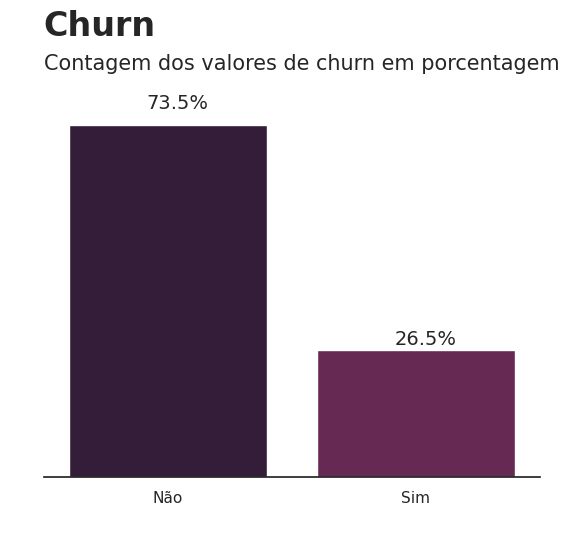

In [7]:
sns.set_theme(style="white", palette="rocket")

fig, ax = plt.subplots()

def bar_percentage(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.2 - 0.05
        y = p.get_y() + p.get_height() * 1.05
        ax.annotate(percentage, (x,y), size = 14)
    plt.show()

ax = sns.countplot(x=df.Churn, data=df)
ax.text(-0.5, 6500, 'Churn', fontsize = 24, fontweight='bold')
ax.text(-0.5, 6000, 'Contagem dos valores de churn em porcentagem', fontsize = 15)

ax.set_xticklabels(['Não', 'Sim'])
ax.set_yticklabels([])
ax.set_ylabel(" ")
ax.set_xlabel(" ")
sns.despine(left=True)

bar_percentage(ax, df.Churn)


A partir daqui é observado que o problema abordado é uma classificação binária. O que seria previsto será os clientes que cancelarão o serviço no mês previsto.

# Análise exploratória

### Análise exploratória das variáveis categóricas

In [24]:
def bar(feature, data=df):
    fig, ax = plt.subplots()

    def bar_percentage(plot, feature):
        total = len(feature)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() / 2.8 - 0.05
            y = p.get_y() + p.get_height() * 1.01
            ax.annotate(percentage, (x,y), size = 14)
        plt.show()

    ax = sns.countplot(x=df[feature], data=df, hue = df.Churn )
    # ax.text(-0.5, 6500, 'Churn', fontsize = 24, fontweight='bold')
    ax.set_title(f'Contagem dos valores de Churn para {feature} em porcentagem', fontsize = 13)

    ax.set_yticklabels([])
    ax.set_ylabel(" ")
    ax.set_xlabel(" ")
    ax.legend(loc='upper right', bbox_to_anchor = (1.2,1))
    sns.despine(left=True)    

    return bar_percentage(ax, df.Churn)

É possível analisar as variáveis categóricas a partir de subconjuntos. As variáveis gener, SeniorCitizen, Partner, Dependets são informação demográficas dos clientes.

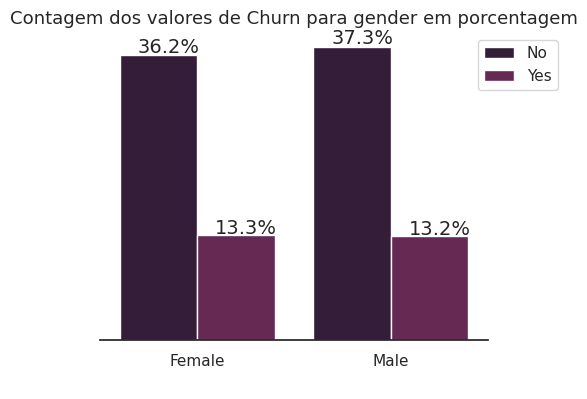

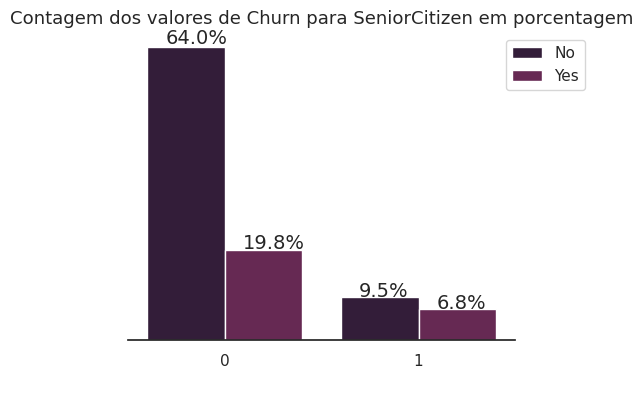

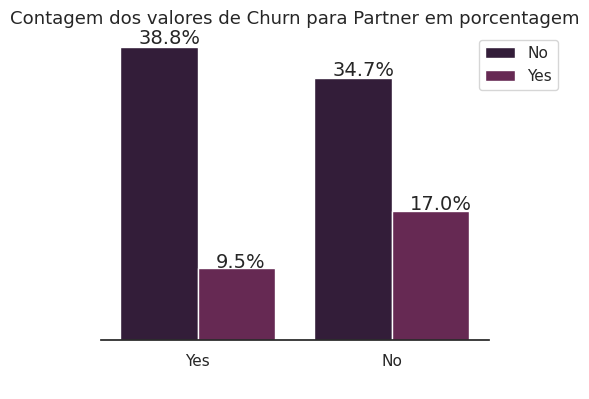

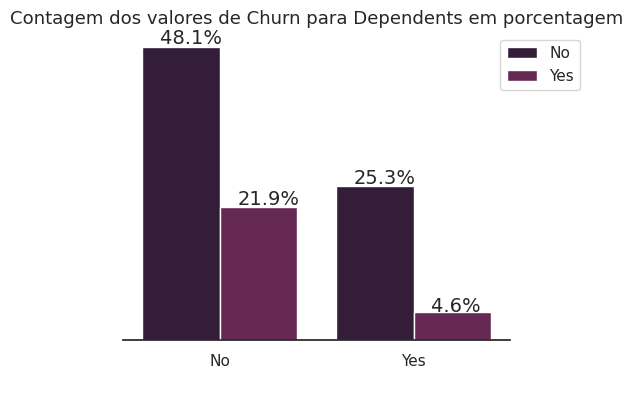

In [14]:
bar('gender')
bar('SeniorCitizen')
bar('Partner')
bar('Dependents')

Em uma análise das variáveis demográficas vemos:
- Há uma diferença muito pequena entre mulheres e homens que cancelam o serviço. 
- Pessoas não aposentadas costumam cancelar mais o serviço (SeniorCitizen = 0), assim como os clientes não casados e os que não possuem dependetes. Isso mostra uma tendência nessa categoria.


Outro subconjunto são das variáveis que representam os seviços assinados pelo cliente: PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreaminTV, StreamingMovies.

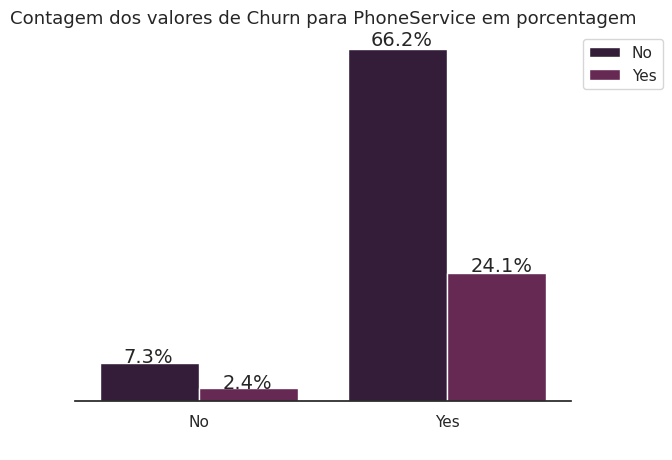

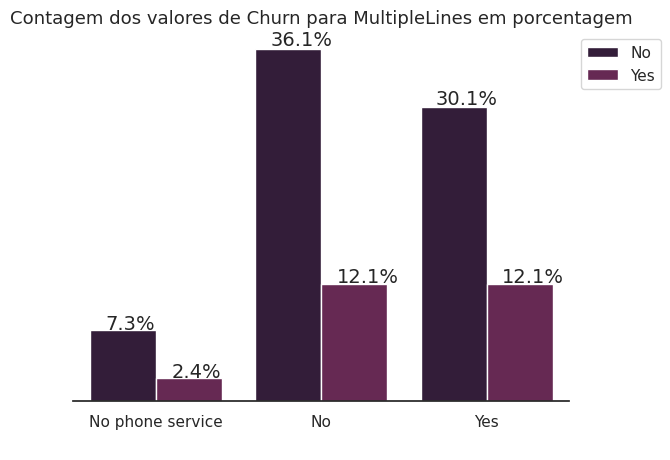

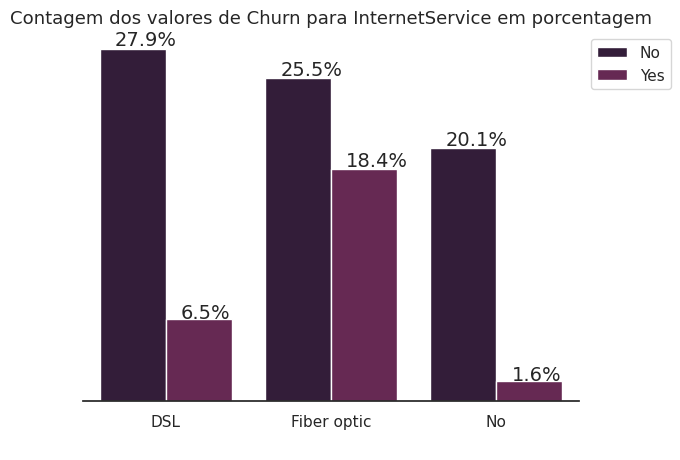

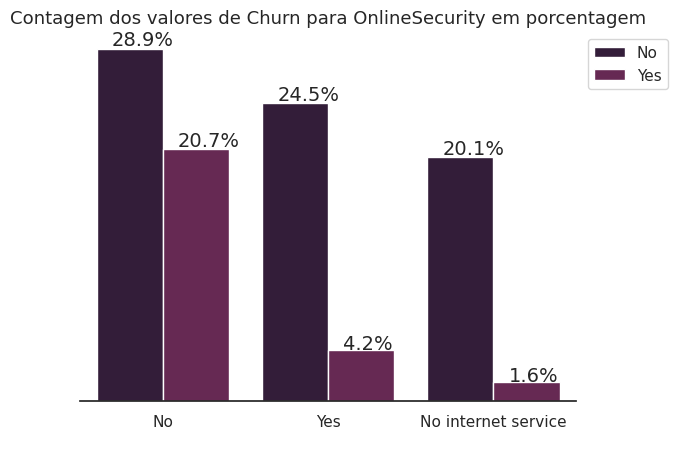

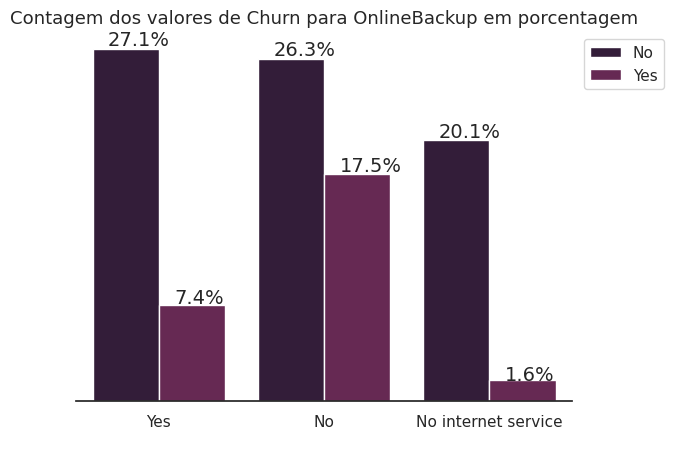

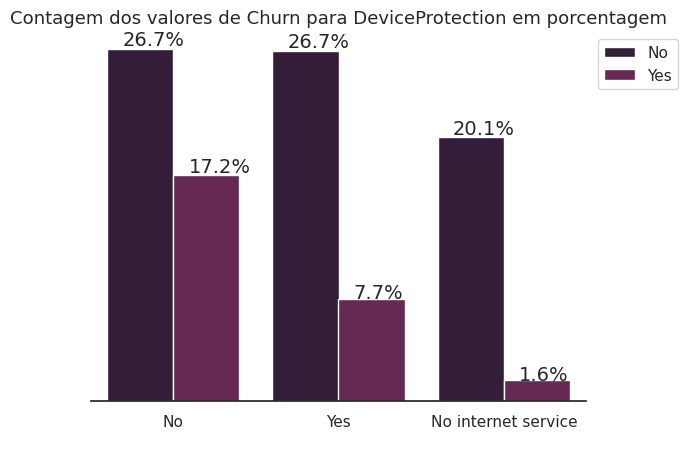

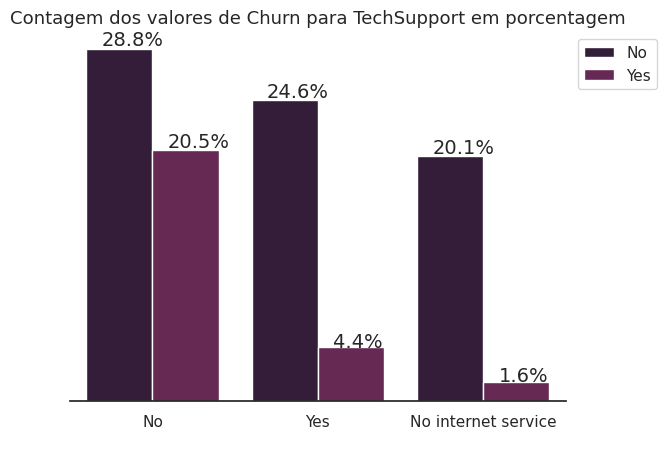

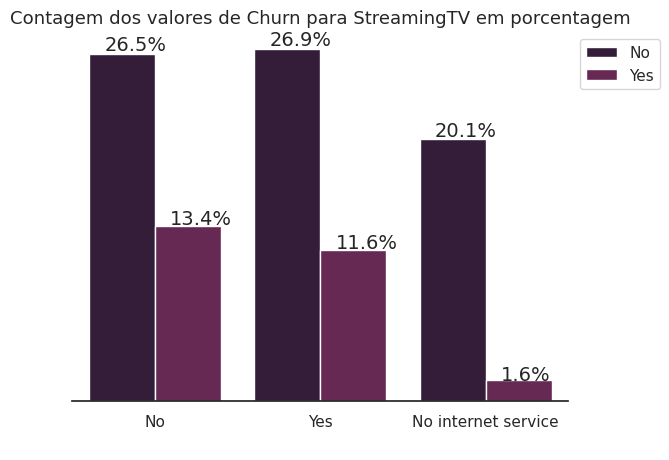

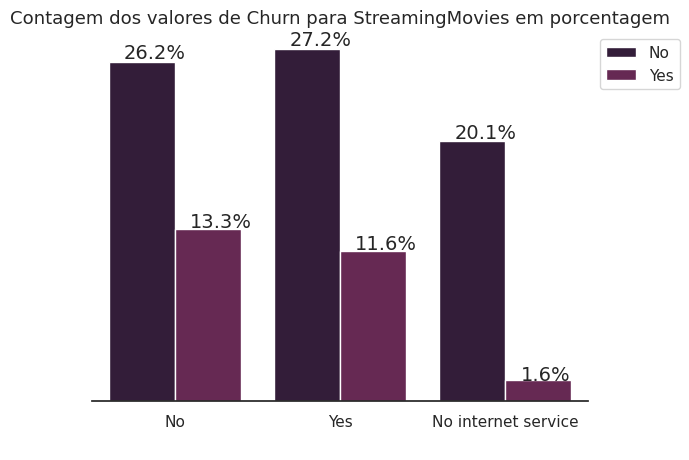

In [22]:
bar('PhoneService')
bar('MultipleLines')
bar('InternetService')
bar('OnlineSecurity')
bar('OnlineBackup')
bar('DeviceProtection')
bar('TechSupport')
bar('StreamingTV')
bar('StreamingMovies')

Sobre a análise de serviços dos clientes podemos observar:
 - É visto que 90.3% dos clientes possuem serviço de telefonia e possuem a maior taxa de cancelamento. 
 - Sobre os serviços de internet, os clientes que possuem Fibra ótica são os que mais cancelam. 
 - Os clientes que assiam os serviçoes de OnlineSecurity, OnlineBackup, DeviceProtection e TechSupport são os que menos cancelam as assinaturas. 
 - Existe um similaridade entre os dados de streaming, podendo até não ser um critério para o cancelamento. 

O ultimo subcojunto de variáveis se refere ao pagamento dos clientes, Contract, PaperlessBilling, PaymentMethod.

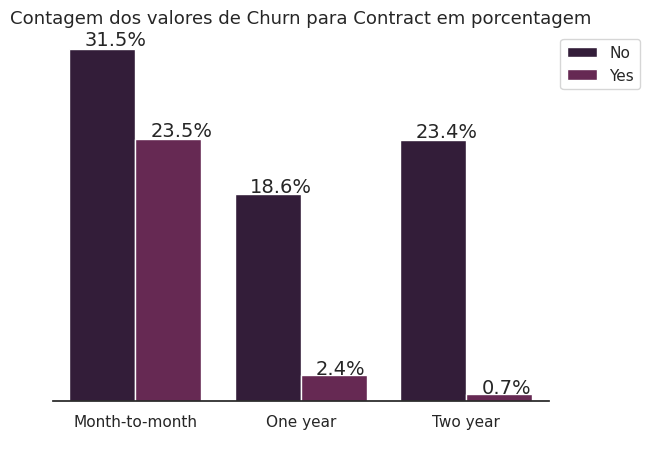

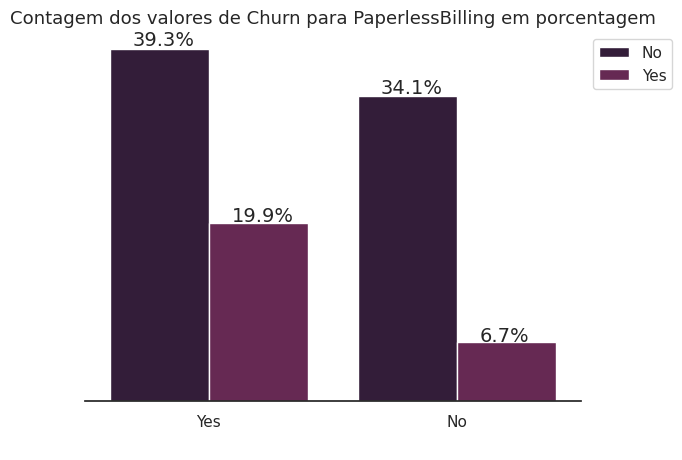

In [23]:
bar('Contract')
bar('PaperlessBilling')

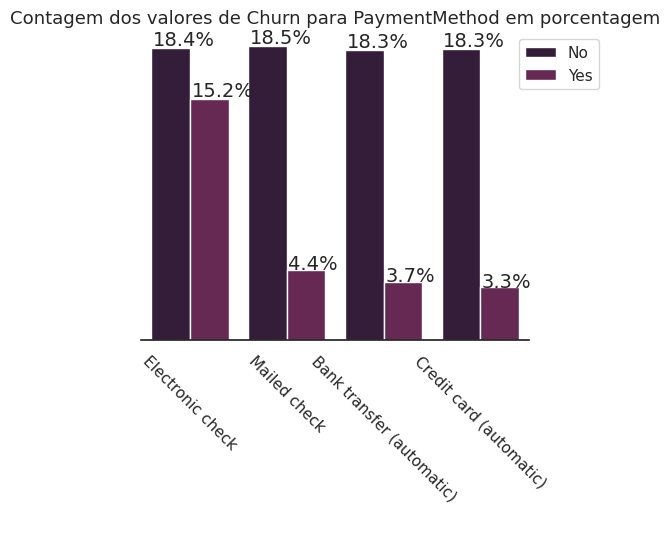

In [25]:
def bar(feature, data=df):
    fig, ax = plt.subplots(figsize = (5,4))

    def bar_percentage(plot, feature):
        total = len(feature)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() / 6 - 0.05
            y = p.get_y() + p.get_height() * 1.01
            ax.annotate(percentage, (x,y), size = 14)
        plt.show()

    ax = sns.countplot(x=df[feature], data=df, hue = df.Churn )
    # ax.text(-0.5, 6500, 'Churn', fontsize = 24, fontweight='bold')
    ax.set_title(f'Contagem dos valores de Churn para {feature} em porcentagem', fontsize = 13)

    ax.set_yticklabels([])
    ax.tick_params(axis = 'x',labelrotation = -45)
    ax.set_ylabel(" ")
    ax.set_xlabel(" ")
    sns.despine(left=True)
    ax.legend(loc='upper right', bbox_to_anchor = (1.2,1))
    plt.savefig(f'count_churns{feature}_.png', dpi=100, bbox_inches='tight')


    return bar_percentage(ax, df.Churn)

bar('PaymentMethod')

A partir da análise dos dados de pagamento dos clientes concluimos que:
- Os clientes com assinaturas mais curtas são os que mais cancelam.
- Aqueles clientes que não possuem faturamento por papel possuem o maior número de cancelamentos.Cerca de 59,2% dos clientes optam por essa opção. 
- E os clientes com o método de pagamento por Electronic check são os que mais tendem a cancelar e esse é o modo mais comum de pagamento.

### Análise exploratória das variáveis numéricas

Antes, é visto um poblema na variável TotalCharges.

In [12]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Essa variável deveria ser numérica, porem está descrita como object. É indicado que há uma string dentro desses dados nessa coluna. 

In [26]:
try:
    df['TotalCharges'] = df['TotalCharges'].astype(float)
except ValueError as error:
    print(error)

could not convert string to float: ''


Aqui é mostrado que há um espaço como valor nessa variável. Para isso é preciso converter essa coluna para numérica e preencher esse valor vazio. 

In [27]:
# convertendo variável TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [28]:
print("Dados ausentes em TotalCharges:\t{}".format(df['TotalCharges'].isnull().sum()))

Dados ausentes em TotalCharges:	11


Acima é verificado que ocorreu a conversão e que agora as strings, " ", se tornaram dados ausentes. 

In [29]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [30]:
print("Dados ausentes em TotalCharges (depois):\t{}".format(df['TotalCharges'].isnull().sum()))

Dados ausentes em TotalCharges (depois):	0


Tanto a conversão e substituição dos valorees ocorreram corretamente. 

In [33]:
#fig, ax = plt.subplots(nrows = 2, ncols=1, constrained_layout = True)
def hist(feature):
    fig, ax = plt.subplots(figsize = (8,4))    
    plt.hist(df[feature][df.Churn=='No'], bins=15, label = 'No')
    plt.hist(df[feature][df.Churn=='Yes'], bins=15, label = 'Yes')
    plt.legend(loc = 'upper right', title = 'Churn', bbox_to_anchor = (1.2,1))
    plt.title(f'Frequência de Churn para distribuição de {feature}', fontsize = 13)
    plt.ylabel('Contagem')
    plt.xlabel(feature)
    sns.despine()
    plt.show()

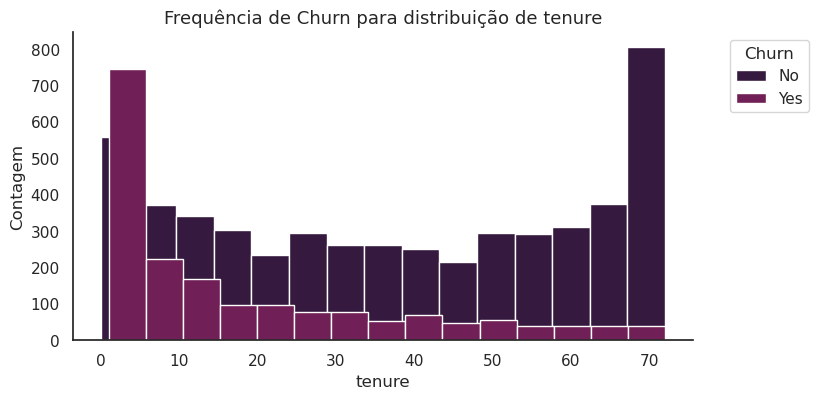

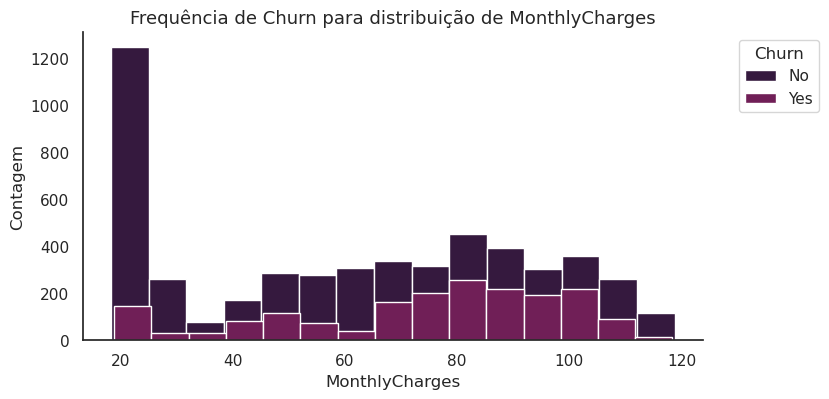

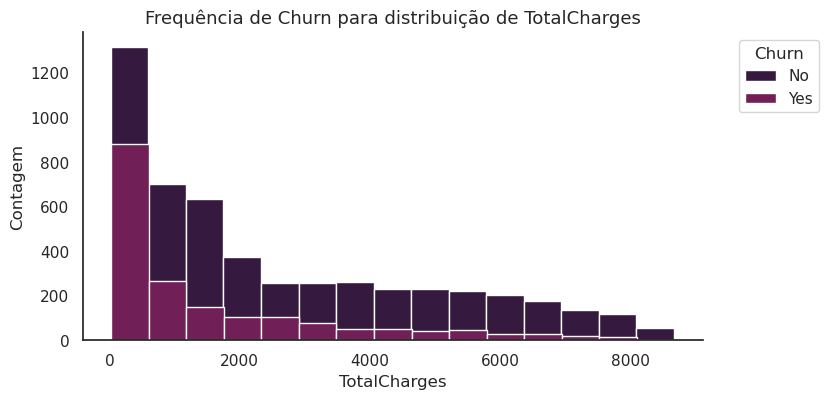

In [34]:
hist('tenure')
hist('MonthlyCharges')
hist('TotalCharges')

Sobre as informações de conta dos clientes pode-se concluir que:
- A empresa teve muitos clienes nos primeiros meses (0-9 meses) e a alta dos cancelamentos aconteceu nesse mesmo período.
- Os clientes que tem um maior valor pago mensalmente são os que também cancelam o serviço. 

# Tratando os dados

In [35]:
df_clean = df.copy()

In [36]:
df_clean.drop(['customerID'], axis=1, inplace=True)

In [37]:
df_clean['gender'] = df_clean['gender'].map({'Male':1, 'Female':0})

In [38]:
binary_list = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for i in binary_list:
    le = LabelEncoder()
    df_clean[i] = le.fit_transform(df_clean[i])
    
df_clean = pd.get_dummies(df_clean, drop_first=True)

In [39]:
df_clean.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

# Modelos de Machine Learning

Primeiramente, é elaborada a divisão dos dados. Divisão dos dados em treino e teste.

In [40]:
X = df_clean.drop('Churn', axis = 1)
y = df_clean['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [41]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)


oversample = SMOTE()
rus = RandomUnderSampler()

X_train, y_train = oversample.fit_resample(X_train, y_train)

In [42]:
def modeling(X, y, model, model_name, quite=False):
    X = np.array(X)
    y = np.array(y)
    
    model = model
    
    acc_score = cross_val_score(model, X, y, scoring = 'accuracy')
    recall_score = cross_val_score(model, X, y, scoring = 'recall')
    precision_score = cross_val_score(model, X, y, scoring = 'precision')
    f_score = cross_val_score(model, X, y, scoring = 'f1')
    
    if quite == False:
        print(model_name)
        print("\nAccuracy: {:.2f} (+/- {:.2f})".format(acc_score.mean(), acc_score.std()))
        print("Recall: {:.2f} (+/- {:.2f})".format(recall_score.mean(), recall_score.std()))
        print("Precision: {:.2f} (+/- {:.2f})".format(precision_score.mean(), precision_score.std()))
        print("F1_score: {:.2f} (+/- {:.2f})".format(f_score.mean(), f_score.std()))

In [43]:
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

In [44]:
modeling(X_train, y_train, dt, 'DecisionTree')
print('\n**************************************')
modeling(X_train, y_train, sgdc, 'SGD')
print('\n**************************************')
modeling(X_train, y_train, svc, 'SVC')
print('\n**************************************')
modeling(X_train, y_train, lr, 'LogisticRegression')
print('\n**************************************')
modeling(X_train, y_train, xgb, 'XGB')
print('\n**************************************')

DecisionTree

Accuracy: 0.77 (+/- 0.05)
Recall: 0.76 (+/- 0.14)
Precision: 0.77 (+/- 0.01)
F1_score: 0.76 (+/- 0.08)

**************************************
SGD

Accuracy: 0.75 (+/- 0.02)
Recall: 0.82 (+/- 0.04)
Precision: 0.74 (+/- 0.02)
F1_score: 0.75 (+/- 0.01)

**************************************
SVC

Accuracy: 0.80 (+/- 0.02)
Recall: 0.83 (+/- 0.06)
Precision: 0.78 (+/- 0.01)
F1_score: 0.80 (+/- 0.03)

**************************************
LogisticRegression

Accuracy: 0.77 (+/- 0.01)
Recall: 0.81 (+/- 0.03)
Precision: 0.75 (+/- 0.01)
F1_score: 0.78 (+/- 0.02)

**************************************
XGB

Accuracy: 0.83 (+/- 0.09)
Recall: 0.82 (+/- 0.21)
Precision: 0.84 (+/- 0.01)
F1_score: 0.81 (+/- 0.12)

**************************************


É visto que o modelo que se destaca nas métricas é SVC e XGB. Porém antes de aplicar qualquer um  deles ao modelo de teste, podemos refinar mais o modelo. Para aumentar um pouco mais os valores das métricas usemos Grid Search para definir os melhores hiperparâmetros para esse modelo. 

### Selecionando Hiperparâmetros para SVC

In [45]:
grid = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
       "C": [100, 10, 1, 0, 0.1, 0.001],
       "gamma": ['scale', 'auto']}

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svc_grid = GridSearchCV(estimator = svc, param_grid=grid, scoring='recall', n_jobs=-1, cv=k_fold)

svc_grid.fit(X_train, y_train)

/home/paulo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/paulo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/paulo/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/paulo/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    ) = libsvm.fit(
  Fi

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0, 0.1, 0.001],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='recall')

In [49]:
print('GridSearch SVC')
print("Melhores parâmetros:\t{}".format(svc_grid.best_params_))
print("Recall: {:.2f}".format(svc_grid.best_score_))

GridSearch SVC
Melhores parâmetros:	{'C': 0.001, 'gamma': 'auto', 'kernel': 'poly'}
Recall: 0.95


In [57]:
svc_final = SVC(C=0.001,
         gamma = 'auto',
         kernel = 'poly')

modeling(X_train, y_train, svc_final, 'SVC')

SVC

Accuracy: 0.61 (+/- 0.01)
Recall: 0.95 (+/- 0.01)
Precision: 0.56 (+/- 0.01)
F1_score: 0.71 (+/- 0.00)


#### Hiperparâmetros XGB

In [50]:
xgb_params = {"n_estimators": [10,100,1000],
              'learning_rate': [0.001,0.01,0.1],
              'subsample': [0.5, 0.7, 1],
              'max_depth': [3,7,9]}



k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_grid = GridSearchCV(estimator = xgb, param_grid=xgb_params, scoring='recall', n_jobs=-1, cv=k_fold)

xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 7, 9],
                         'n_estimators': [10, 100, 1000],
                         'subsample': [0.5, 0.7, 1]},
             scoring='recall')

In [52]:
print('GridSearch XGB')
print("Melhores parâmetros:{}".format(xgb_grid.best_params_))
print("Recall: {:.2f}".format(xgb_grid.best_score_))

GridSearch XGB
Melhores parâmetros:{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1}
Recall: 0.91


In [56]:
xgb_final = XGBClassifier(learning_rate = 0.001, max_depth = 3, n_estimators = 10, subsample = 1)

modeling(X_train, y_train, xgb_final, 'XGB')

XGB

Accuracy: 0.74 (+/- 0.02)
Recall: 0.91 (+/- 0.02)
Precision: 0.68 (+/- 0.01)
F1_score: 0.78 (+/- 0.01)


Vemos que o modelo que melhor se sai na métrica é o SVC.

## Aplicação do modelo nos dados de teste

              precision    recall  f1-score   support

           0       0.92      0.26      0.41      1302
           1       0.31      0.94      0.47       459

    accuracy                           0.44      1761
   macro avg       0.62      0.60      0.44      1761
weighted avg       0.76      0.44      0.42      1761

AUC: 0.6008



<AxesSubplot:>

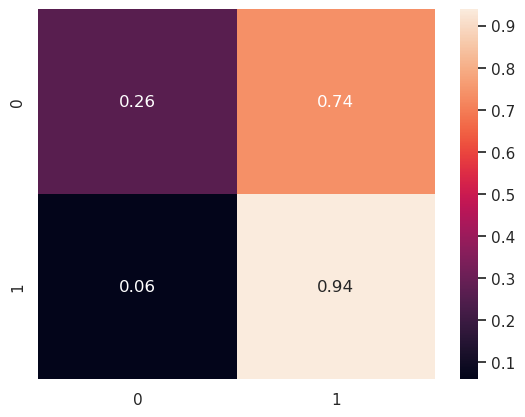

In [59]:
svc_final.fit(X_train, y_train)


scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)
y_pred = svc_final.predict(X_test)

print(classification_report(y_test, y_pred))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f')

# Conclusão

O projeto sobre Churn rate consistiu sobre uma análise exploratória dos dados e os estudo de alguns modelos de Machine Learning.

Na análise exploratório foi possível ver o perfil dos clientes que mais cancelam o serviço. Com isso pode até ser possível criar estratégias que se adequam as individualidades dos clientes podendo os manter mais tempo no serviço.

O modelo que melhor se adequou, com a métrica recall avaliada, foi o SVC. Com aplicação de GridSearch foi possivel instanciar os hiperparâmetros para assim pode aplicar o modelo nos dados de teste. 